In [1]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from shap.plots._beeswarm import summary_legacy

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from CML_tool.ShapUtils import calculate_shap_values, CI_shap
from CML_tool.ExplorativePlots import kde_rugplot_multivar

In [2]:
# Set up binary classification problem
iris_data = load_iris()
X = iris_data.data
y = iris_data.target
y = np.where(y == 1, 1, 0)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_test.shape

(30, 4)

In [3]:
# Train a logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [4]:
# Logistic regression
# warnings.filterwarnings("ignore", category=UserWarning) # Ignore the function warnings
warnings.filterwarnings("default", category=UserWarning) # See the function warnings

log_shap = calculate_shap_values(
    model=log_reg,
    background_data=X_train,
    training_outcome=y_train,
    test_data=X_test,
    pretrained=True,
    explainer_type='linear',
    link_function='identity',
    feature_perturbation='observational'
    )

                LinearExplainer ignores the passed link function and always uses identity pre logistic transformation.
                Hence, shapley values are computed in log-odds space.
                For marginal probability contributions apply a logistic function to the provided output.
                
                The LinearExplainer uses the Impute masker intead of the Partition masker.
                          


In [5]:
# Train a random forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [6]:
# Tree-based models
# warnings.filterwarnings("ignore", category=UserWarning) # Ignore the function warnings
warnings.filterwarnings("default", category=UserWarning) # See the function warnings

rf_shaps_obvs, explainer_obvs = calculate_shap_values(
    model=rf,
    background_data=X,
    training_outcome=y,
    test_data=X,
    pretrained=True,
    explainer_type='tree',
    link_function='identity',
    feature_perturbation='observational',
    retrieve_interactions=False,
    max_samples=5000
    )

rf_shaps_ind, explainer_ind = calculate_shap_values(
    model=rf,
    background_data=X,
    training_outcome=y,
    test_data=X,
    pretrained=True,
    explainer_type='tree',
    link_function='identity',
    feature_perturbation='interventional_independent',
    retrieve_interactions=False,
    max_samples=5000
    )

rf_interactions, explainer_int = calculate_shap_values(
    model=rf,
    background_data=X,
    training_outcome=y,
    test_data=X,
    pretrained=True,
    explainer_type='tree',
    link_function='identity',
    feature_perturbation='observational',
    retrieve_interactions=True,
    max_samples=5000
    )

                          TreeSHAP with 'observational' (i.e. 'tree_path_dependent') feature perturbation
                          uses the trees pathways followed by training samples during learning 
                          to obtain the backgroun distribution and compute observational expectations.
                          
                          'tree_path_dependent' feature perturbation forces 'raw' as the output format being 
                          explained by Shapley values. This is the output from the decission trees. 
                          For most sklearn classifiers expressed in probability, but for XGBoost classifier
                          this is log-odds ratio (i.e. marginal contribution of the feature in log-odds units). 
                          Note that post-computation transformation (e.g. log-odds -> prob via a logistic) cannot be done 
                          exactly for Tree SHAP values.
                          
                          Tree

In [7]:
# direct effects
main_effects = np.diagonal(rf_interactions, axis1=1, axis2=2)
# indirect effects
mask = ~np.eye(rf_interactions.shape[-1], dtype=bool)
off_diagonals = rf_interactions[:, mask].reshape(X.shape[0], 3, 4)

Total additive error (SHAP - sum(main + interaction effects)): 
Observational:  -7.026063758575063e-15
Interventional:  4.34749999948079


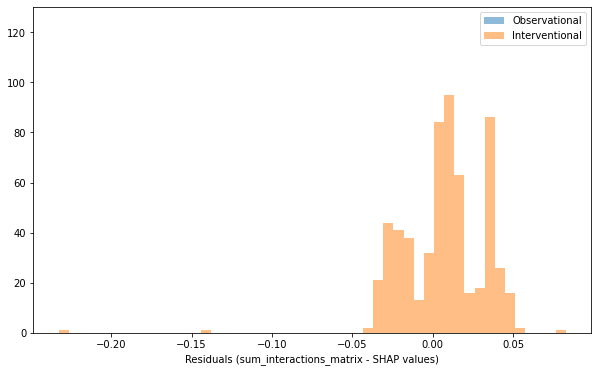

In [8]:
# Check that sum of interaction values adds up to the SHAP values
print('Total additive error (SHAP - sum(main + interaction effects)): ')
print('Observational: ', sum(sum(rf_interactions.sum(axis=1)-rf_shaps_obvs)))
print('Interventional: ', sum(sum(rf_interactions.sum(axis=1)-rf_shaps_ind)))

total_effects = rf_interactions.sum(axis=1)
res_obvs = total_effects-rf_shaps_obvs
res_ind = total_effects-rf_shaps_ind

# Plot the SHAP values
fig = plt.figure(figsize=(10, 6))
plt.hist(res_obvs.ravel(), bins=50, alpha=.5, label='Observational')
plt.hist(res_ind.ravel(), bins=50, alpha=.5, label='Interventional')
plt.xlabel('Residuals (sum_interactions_matrix - SHAP values)')
plt.legend()

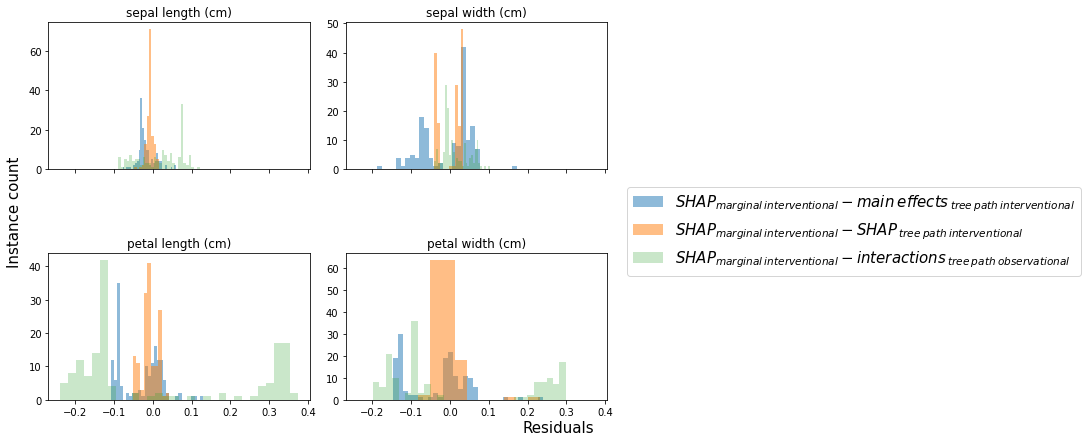

In [58]:
# residuals
res_main = rf_shaps_ind-main_effects
res_obvs = rf_shaps_ind-rf_shaps_obvs
res_inter = rf_shaps_ind-off_diagonals.sum(axis=1)

# # residuals of absolute effects
# res_main = abs(rf_shaps_ind)-abs(main_effects)
# res_obvs = abs(rf_shaps_ind)-abs(rf_shaps_obvs)
# res_inter = abs(rf_shaps_ind)-abs(off_diagonals.sum(axis=1))

fig,axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 6), sharex=True, sharey=False)

for (i, feature), ax in zip(enumerate(iris_data.feature_names), axes.ravel()):
    ax.hist(res_main[:,i].flatten(), bins=30, alpha=0.5, label=r'$SHAP_{marginal\:interventional}-main\:effects_{\:tree\:path\:interventional}$')
    ax.hist(res_obvs[:,i].flatten(), alpha=0.5, label=r'$SHAP_{marginal\:interventional}-SHAP_{\:tree\:path\:interventional}$')
    ax.hist(res_inter[:,i].flatten(), bins=30, alpha=0.25, label=r'$SHAP_{marginal\:interventional}-interactions_{\:tree\:path\:observational}$')
    ax.set_title(feature)

fig.text(0.5, -0.01, 'Residuals', ha='center', fontsize=15)
fig.text(-0.01, 0.5, 'Instance count', va='center', rotation='vertical', fontsize=15)
plt.legend(fontsize=15, ncol=1, bbox_to_anchor=(1.05, 1.5))

plt.tight_layout()

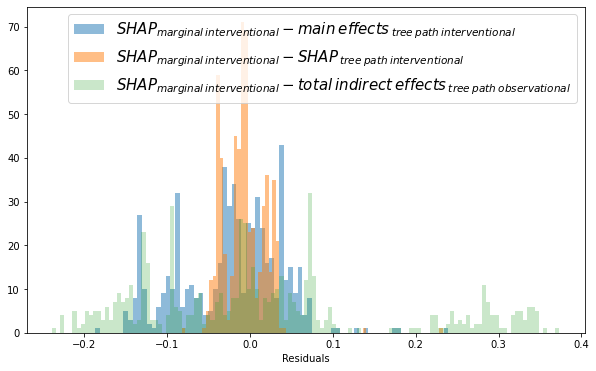

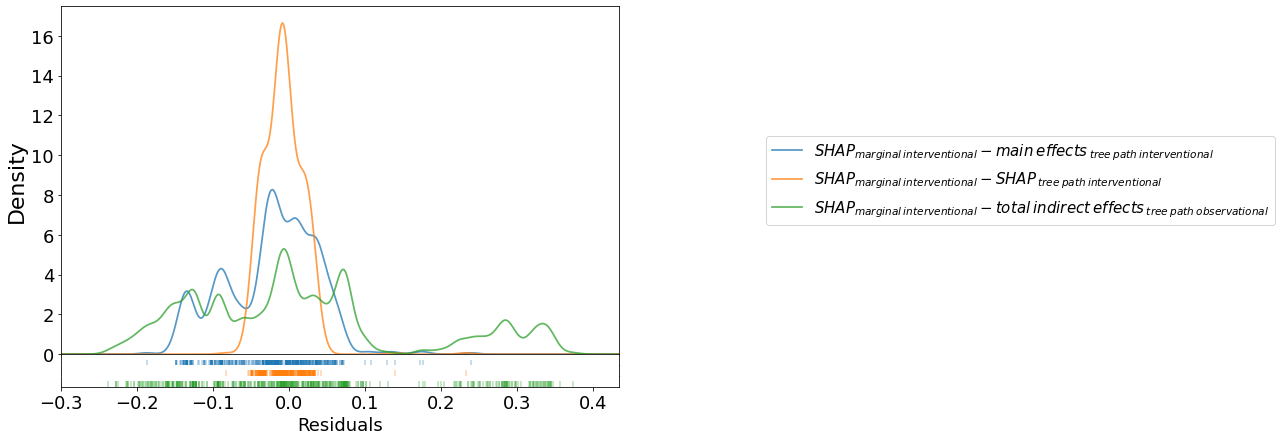

In [59]:
# Check whether interventional SHAP values are equal to the main effects
fig = plt.figure(figsize=(10, 6))

plt.hist(res_main.flatten(), bins=75, alpha=0.5, label=r'$SHAP_{marginal\:interventional}-main\:effects_{\:tree\:path\:interventional}$')
plt.hist(res_obvs.flatten(), bins=75, alpha=0.5, label=r'$SHAP_{marginal\:interventional}-SHAP_{\:tree\:path\:interventional}$')
plt.hist(res_inter.flatten(), bins=125, alpha=0.25, label=r'$SHAP_{marginal\:interventional}-total\:indirect\:effects_{\:tree\:path\:observational}$')
plt.xlabel('Residuals')
plt.legend(fontsize=15, ncol=1)


df = pd.DataFrame(data={
    r'$SHAP_{marginal\:interventional}-main\:effects_{\:tree\:path\:interventional}$': pd.Series(res_main.flatten()),
    r'$SHAP_{marginal\:interventional}-SHAP_{\:tree\:path\:interventional}$': pd.Series(res_obvs.flatten()),
    r'$SHAP_{marginal\:interventional}-total\:indirect\:effects_{\:tree\:path\:observational}$': pd.Series(res_inter.flatten())
}
)

fig_kde = kde_rugplot_multivar( 
    df,
    kde_kwargs={'bandwidth': 0.01, 'alpha': 0.75, 'kernel':'gaussian', 'linewidth':1.75, },
    figsize=(10, 7),
    xlabel='Residuals',
    ylabel='Density',
    legend_kwargs={'fontsize':15,'bbox_to_anchor':(1.25, 0.5), 'loc':'center left'},
    show=True
)

# TODO: Why are there residuals betweem marginal shap values and main effects?
# Maybe those differences occur because the features are not root in this dataset?

In [11]:
print(f'\t Feature \t|    mav TOTAL effect\t|      mav DIRECT effects\t| mav INDIRECT effects [95% top percetile]')
print(125*'-')

# indirect effects
indirect_effects = np.mean(np.mean(abs(off_diagonals), axis=1), axis=0)
top_indirect_effects =  np.percentile(np.mean(abs(off_diagonals), axis=1), 95, axis=0)

# direct effect 
direct_effects = np.mean(np.diagonal(abs(rf_interactions), axis1=1, axis2=2),axis=0)

# total effects
mav = np.mean(abs(rf_shaps_obvs), axis=0)

for sh, de, ie, iet, feature in zip(
    mav,
    direct_effects,
    indirect_effects,
    top_indirect_effects,
    iris_data['feature_names']):
    
    print(f'{feature}\t|\t {sh:.5f} \t|\t {de:.5f}\t\t|\t\t{ie:.5f}[{iet:.5f}]\t')
    print(125*'-')

	 Feature 	|    mav TOTAL effect	|      mav DIRECT effects	| mav INDIRECT effects [95% top percetile]
-----------------------------------------------------------------------------------------------------------------------------
sepal length (cm)	|	 0.02015 	|	 0.02855		|		0.01982[0.03281]	
-----------------------------------------------------------------------------------------------------------------------------
sepal width (cm)	|	 0.04814 	|	 0.07235		|		0.01098[0.02236]	
-----------------------------------------------------------------------------------------------------------------------------
petal length (cm)	|	 0.19322 	|	 0.16793		|		0.01098[0.02236]	
-----------------------------------------------------------------------------------------------------------------------------
petal width (cm)	|	 0.18733 	|	 0.15507		|		0.01982[0.03281]	
-----------------------------------------------------------------------------------------------------------------------------


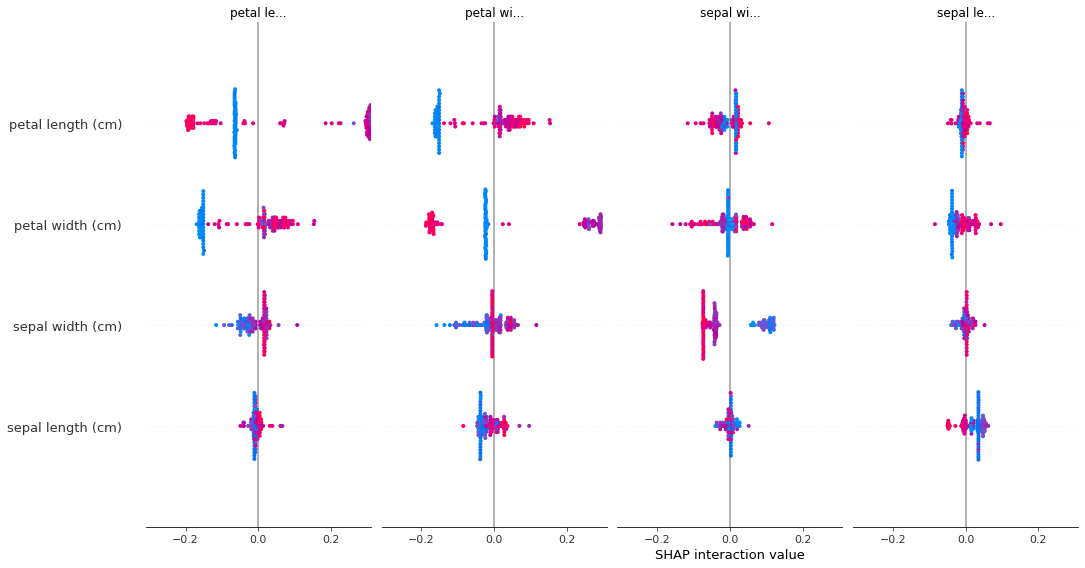

In [12]:
summary_legacy(rf_interactions, features=X, feature_names=np.array(iris_data['feature_names']), color_bar=True, show=False)
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(25, 8)  
plt.tight_layout()


In [13]:
warnings.filterwarnings("ignore", category=UserWarning) # Ignore the function warnings

shap_iter_unc = CI_shap(
    model=rf,
    background_data=X_train,
    training_outcome=y_train,
    test_data=X_test,
    test_outcomes=y_test,
    randomness_distortion='seeds',
    explainer_type='tree',
    link_function='identity',
    feature_perturbation='observational',
    MC_repeats=5,
    n_jobs=5,
    retrieve_interactions=True
)

100%|██████████| 5/5 [00:00<00:00, 23.94it/s]
                          TreeSHAP with 'observational' (i.e. 'tree_path_dependent') feature perturbation
                          uses the trees pathways followed by training samples during learning 
                          to obtain the backgroun distribution and compute observational expectations.
                          
                          'tree_path_dependent' feature perturbation forces 'raw' as the output format being 
                          explained by Shapley values. This is the output from the decission trees. 
                          For most sklearn classifiers expressed in probability, but for XGBoost classifier
                          this is log-odds ratio (i.e. marginal contribution of the feature in log-odds units). 
                          Note that post-computation transformation (e.g. log-odds -> prob via a logistic) cannot be done 
                          exactly for Tree SHAP values.
           